# Prerequisites
conda install graphviz pygraphviz -c alubbock

Perform *dot -c* in conda prompt

# Content
This notebook displays the (Original) Collatz Tree, the Syracuse Tree (which only contains odd labeled nodes) and also pruned trees according to Kleinnijenhuis:
* https://arxiv.org/abs/2008.13643

Please note that this is a "quick & dirty" artifact for illustrative purpose only. For professional use. please use the comprehensive API provided by Christian Koch:
* https://github.com/c4ristian/collatz/tree/v1.3.2
* https://github.com/c4ristian/collatz/blob/v1.3.2/collatz/graph.py
* https://github.com/c4ristian/collatz/blob/v1.3.2/tests/test_graph.py
* https://github.com/c4ristian/collatz/blob/v1.3.2/notebooks/dutch_graph.md


In [95]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [96]:
class Node:
    ORANGE = "#ffbe27"
    BLUE = "#c3d9ff"
    GREY = "#d3d3d3"

    successors = []
    row = 0

    def __init__(self, predecessor, label):
        self.predecessor = predecessor
        self.label = label
        if predecessor != None:
            self.row = predecessor.row + 1
    
    def addSuccessor(successor):
        self.successors.append(successor)


In [97]:
def discrete_log(exp_start, factor, base=2, power=1, modulus=3):
    exp = exp_start
    while (res := factor * base**exp - 1):
        if res % 3 == 0:
            return exp
        else:
            exp += 1

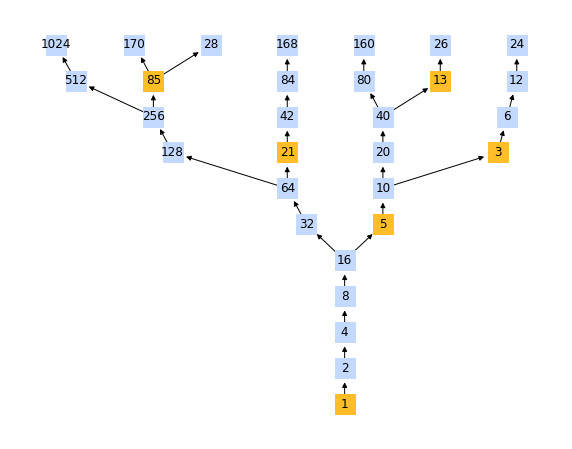

In [98]:
#Original Collatz Tree
nodelist = []
predecessor_successor_array = [[]]
max_height = 10
def generate_tree_collatz(node):
    nodelist.append(node.label)
    if node.row < max_height:
        left_child = Node(node, node.label * 2)
        predecessor_successor_array.append([node.label,left_child.label])
        if (node.label - 1) % 3 == 0:
            right_child_label = (node.label - 1) / 3
            if right_child_label > 0 and right_child_label not in nodelist:
                right_child = Node(node, right_child_label)
                predecessor_successor_array.append([node.label,right_child.label])
                generate_tree_collatz(right_child)
        generate_tree_collatz(left_child)

root = Node(None, 1)
generate_tree_collatz(root)
columns = ['predecessorId', 'successorId']
df = pd.DataFrame(columns = columns, data=predecessor_successor_array)
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
df[columns] = df[columns].astype('int')

G = nx.from_pandas_edgelist(df, 'predecessorId', 'successorId', create_using=nx.DiGraph)
node_colors = []
for node in G:
    node_colors.append(Node.BLUE) if node % 2 == 0 else node_colors.append(Node.ORANGE)

pos = graphviz_layout(G, prog="dot", root=1, args='-Gsplines=true -Gsep=1 -Goverlap=false -Gorientation=10')
plt.figure(figsize=(10, 8))
plt.gca().invert_yaxis()
nx.draw(G, node_color=node_colors, pos=pos, with_labels=True,  node_shape="s", node_size=400, linewidths=1)
#nx.draw(G, node_color=node_colors, pos=pos, with_labels=True,  node_shape="s", bbox=dict(facecolor='skyblue', edgecolor='black', boxstyle='round,pad=0.2'))
#list(nx.selfloop_edges(G))

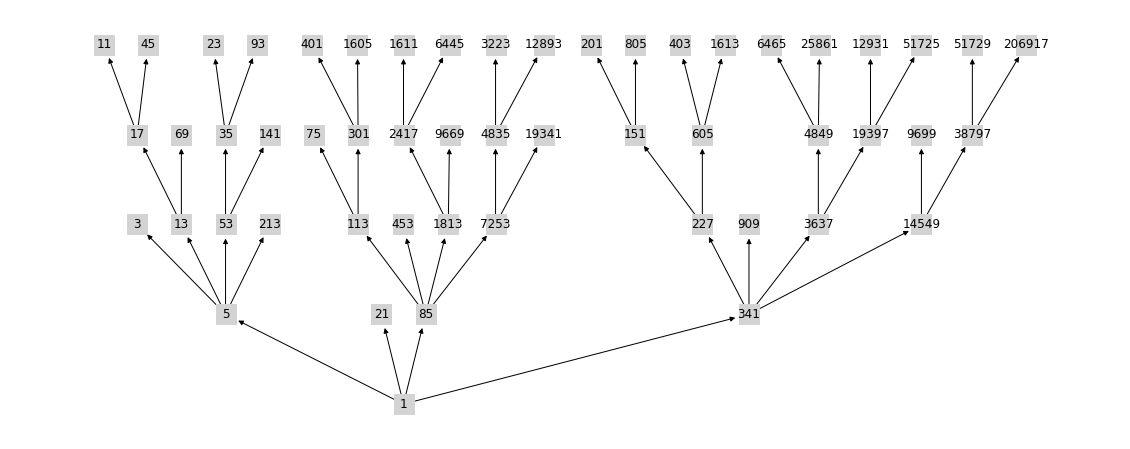

In [99]:
#Syracuse Tree
nodelist = []
predecessor_successor_array = [[]]
max_height = 4
max_children_per_row = [5,4,2,2]
def generate_tree_syracuse(node):
    nodelist.append(node.label)
    if node.row < max_height and node.label % 3 > 0:
        exp = 1
        for i in range(max_children_per_row[node.row]):
            exp = discrete_log(exp, node.label)
            child_label = (node.label * 2**exp - 1) / 3
            if child_label not in nodelist:
                child = Node(node, child_label)
                predecessor_successor_array.append([node.label,child.label])
                generate_tree_syracuse(child)
            exp += 1

root = Node(None, 1)
generate_tree_syracuse(root)

columns = ['predecessorId', 'successorId']
df = pd.DataFrame(columns = columns, data=predecessor_successor_array)
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
df[columns] = df[columns].astype('int')

G = nx.from_pandas_edgelist(df, 'predecessorId', 'successorId', create_using=nx.DiGraph)
pos = graphviz_layout(G, prog="dot", root=1, args='-Gsplines=true -Gsep=1 -Goverlap=false -Gorientation=10')
plt.figure(figsize=(20, 8))
plt.gca().invert_yaxis()
nx.draw(G, node_color=Node.GREY, pos=pos, with_labels=True,  node_shape="s", node_size=400, linewidths=1)